In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# from before
def phase_plot(genfn, xlim, ylim, nx, ny, ax, scale=False, **kwargs):
    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], nx),
                       np.linspace(ylim[0], ylim[1], ny))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    if scale:
        q = ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
    else:
        q = ax.quiver(X, Y, U-X, V-Y, angles='xy')
    return q

def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        N[t, :], M[t, :] = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
    return N, M


# Linear algebra, age structure, and eigenpopulations

Next we'll be learning some *linear algebra*, which gives us
the tools we need to generalize what we've done so far to higher dimensions.
We'll follow Otto & Day in doing this in the context of 
*age* and *stage structured populations*.

We're also going to focus on the *short term* dynamics of these populations:
for reasons that will be clear later, we won't be concerned about long-term stability.


# Linear algebra

A quick intro on the board to:

1. Vector addition (`+`): vectors as *displacements*
2. Matrix-vector multiplication (`@`): square matrices as *transformations*
3. Matrix-matrix multiplication (`@`): *composing* two transformations
4. Matrices as systems of linear equations (`np.linalg.solve( )`)

Problems: let
$$
  M = \begin{bmatrix} 1 & 2 & 3 \\ 0 & 4 & 5 \\ 0 & 0 & 6 \end{bmatrix}
$$
and
$$\begin{aligned}
 x = \begin{bmatrix} 3 \\ -6 \\ 9 \end{bmatrix}
 & \qquad &
 y = \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} .
\end{aligned}$$


1. Find $x + y$.
2. Find $M x$.
3. Show that $M(x+y) = Mx + My$.
4. Show that $M(Mx) = (M^2)x$.
5. Find the vector $u$ so that $Mu = x$.

In [ ]:
# 1. find x + y
x = np.array([3, -6, 9])
y = np.array([1, 1, 1])
print("x + y", x + y)

# 2 find Mx
M = np.array([[1, 2, 3],
              [0, 4, 5],
              [0, 0, 6]])
print("Mx", M @ x)
print(" or ", np.matmul(M, x))

# 3. Show that matrix multiplication is distributive
if np.all(M @ (x + y) == M @ x + M @ y):
    print("M(x+y) == Mx + My")
else:
    print("oh no!!!")
    
# 4. Show that matrix multiplication is associative
if np.all( (M @ M) @ x == M @ (M @ x) ):
    print("M^2 x == M (Mx)")
else:
    print("oh no!!")
    
# 5. Find u such that Mu = x
u = np.linalg.solve(M, x)
print("It is", u)
print("since Mu is", M @ u)

In [ ]:
M @ M


# Life stages (aka class-structured populations)

Let's go back to thinking about a single species,
but keeping track not just of how many individuals there are,
but also what *life stage* or *class* they are all in.
We *could* keep track of this just as a list of life stages -
if there are $N$ individuals, this would be a list of $N$ numbers.
But it's tidier to keep track of the *census*:
for each possible class, how many individual are there of that age?
We'll write that as follows:
$$
  N_k(t) = \text{(number of class-$k$ individuals alive at time $t$)} .
$$


## Example: juveniles/adults

Let's start with the simplest example.
- Every individual is either *juvenile* (class $J$) or *adult* (class $A$).
- Juveniles *mature* into adults with probability $p_j$, or else die.
- Adults give birth to on average $b$ offspring per time step, and
- survive to the next time step with probability $p_a$.

The discrete-time (deterministic) equation is
$$ \begin{aligned}
  N_J(t+1) &= 0 N_J(t) +  b N_A(t) \\
  N_A(t+1) &= p_j N_J(t) + p_a N_A(t) .
\end{aligned} $$
Using the matrix
$$\begin{aligned}
M =
\begin{array}{c c} & \begin{array}{@{} c c @{}} J\hphantom{0} & \hphantom{0}A \end{array} \\
    \begin{array}{c} J \\ A \end{array}\hspace{-1em} &
    \left(
        \begin{array}{@{} c  @{}}
        0 & b \\
        p_j & p_a
        \end{array}
    \right) \\ \mbox{} \end{array} \\[-12pt] ,
\end{aligned}$$
and $N = (N_J, N_A)$,
we can write this same system of equations concisely as
$$
N(t+1) = M N(t) .
$$

**What's this system do?**

In [4]:
# The parameters
b = 10
pj = 0.1
pa = 0.2
M = np.array([[0, b], [pj, pa]])
print(M)

[[ 0.  10. ]
 [ 0.1  0.2]]


In [5]:
# suppose we start with one juvenile and 9 adults?
print(M @ np.array([1, 9]))

[90.   1.9]


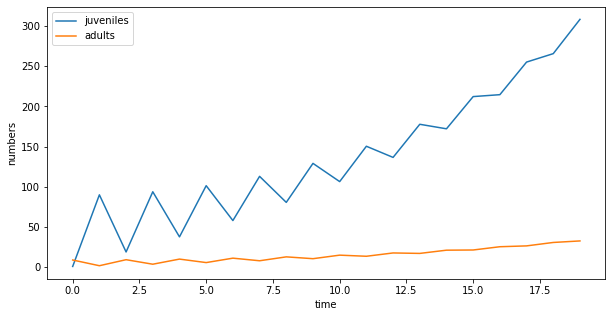

In [6]:
# iterate these equations
N0 = [1, 9]
ntimes = 20
N = np.empty((ntimes, 2), dtype='float')
N[0,:] = N0
for j in range(1, ntimes):
    N[j, :] = M @ N[j-1, :]
    
fig, ax = plt.subplots()
ax.plot(N)
ax.set_xlabel("time")
ax.set_ylabel("numbers")
ax.legend(['juveniles', 'adults']);

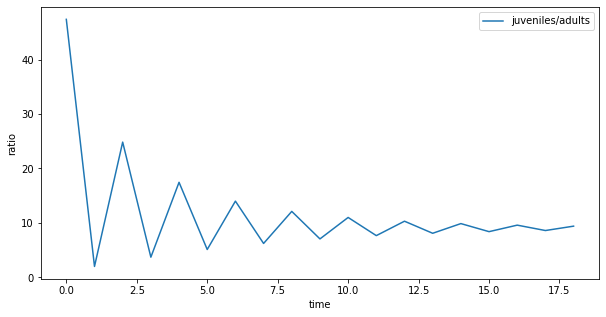

In [7]:
# plot the ratio of juveniles to adults
    
fig, ax = plt.subplots()
ax.plot(N[1:,0]/N[1:,1])
ax.set_xlabel("time")
ax.set_ylabel("ratio")
ax.legend(['juveniles/adults']);

# Eigendirections

*Eigenvectors* of a matrix are directions *unchanged* by its transformation.
In symbols, this is
$$
  Mv = \lambda v
$$
where $\lambda$ is a *number*, called the *eigenvalue*.

Exercises:

1. Check that $(1, 0)$ and $(0, 1)$ are eigenvectors of
    $$
    M = \begin{bmatrix} 2 & 0 \\ 0 & 3 \end{bmatrix} .
    $$
    What are the eigenvalues?

2. Use `np.linalg.eig( )` to find the eigenvalues and vectors of 
    $$
      M = \begin{bmatrix} 1 & 2 & 3 \\ 0 & 4 & 5 \\ 0 & 0 & 6 \end{bmatrix}
    $$
    Double-check the equation holds.

3. The formula corresponding to "change into the coordinates of the eigenvectors,
    multiply by the eigenvalues, and change coordinates back" is
    $$
      M = U \text{diag}(\lambda) U^{-1} ,
    $$
    where $U^{-1}$ is the *inverse matrix* (`scipy.linalg.solve(U, np.eye(U.shape[0]))`)
    and $\text{diag}(\lambda)$ is the matrix with the values of $\lambda$ on the diagonal
    and zeros elsewhere.
    Check this holds.


In [13]:
# 2. 
M = np.array([[1, 2, 3],
              [0, 4, 5],
              [0, 0, 6]])
lam, U = np.linalg.eig(M)
print("e'values", lam)
print("e'vectors", U)

print("Mu", M @ U[:, 1])
print("lam u", lam[1] * U[:, 1])

e'values [1. 4. 6.]
e'vectors [[1.         0.5547002  0.51084069]
 [0.         0.83205029 0.79818857]
 [0.         0.         0.31927543]]
Mu [2.21880078 3.32820118 0.        ]
lam u [2.21880078 3.32820118 0.        ]


### Example: eigenvectors

Here's the vector field defined by the transformation we get from
$$
  M = \begin{bmatrix} 2 & 1 \\ 1/2 & 1 \end{bmatrix} ,
$$
with the eigenvector directions superimposed.

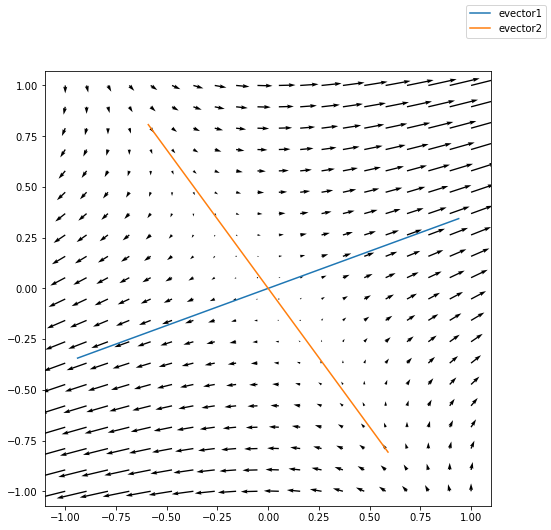

In [8]:
M = np.array([[2, 1], [1/2, 1]])
lam, U = linalg.eig(M)

def lin_transform(X, Y, M):
    out = M @ np.row_stack([X, Y])
    return out[0, :], out[1, :]

plt.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots()
phase_plot(lin_transform, [-1, 1], [-1, 1], 20, 20, ax=ax, M=M)
plt.axis("equal")
for x, y in U.T:
    ax.plot([-x, x], [-y, y])

fig.legend(['evector1', 'evector2']);

In [9]:
np.linalg.eig(M)

(array([2.3660254, 0.6339746]),
 array([[ 0.9390708 , -0.59069049],
        [ 0.34372377,  0.80689822]]))

## Eigenanalysis of a stage-structured model

We're going to find the time course of the linear model
$$
   N(t) = M^t N(0) ,
$$
using the eigendecomposition of $M$.
If we can do an eigendecomposition, it looks like 
$$
  M = U \text{diag}(\lambda) U^{-1} ,
$$
and so
$$
  M^t = U \text{diag}(\lambda^t) U^{-1} .
$$

Written out, this says that to find the vector $N(t)$, we need to

1. Find the eigenvector loadings of the initial state:
   $$ V(0) = U^{-1} N(0) . $$
   These say how strongly the initial state "excites" each of the eigendirections.
  
2. Multiply each of these loadings by the corresponding eigenvalue to the power $t$, i.e., $\lambda^t$:
   $$ V(t)_k = \lambda_k^t V(0)_k . $$
   These give the contributions of each eigendirection at time $t$.
  
3. Shift back to the original coordinates by multiplying by the matrix of eigenvectors, $U$:
   $$ N(t) = U V(t) .$$



### Eigenanalysis of the juvenile-adult example

We'll apply this to the juvenile-adult model above.

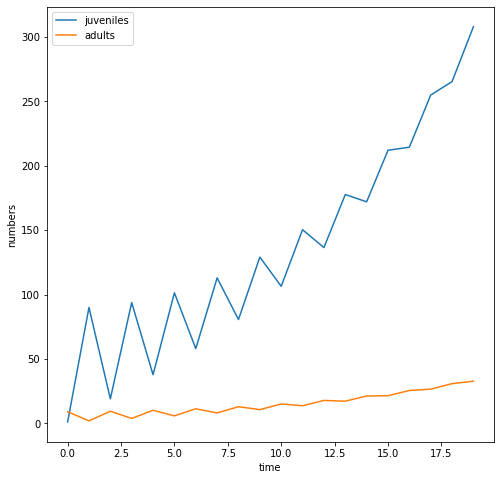

In [14]:
# The parameters
b = 10
pj = 0.1
pa = 0.2
M = np.array([[0, b], [pj, pa]])
lam, U = linalg.eig(M)  # eigenvalue, vector

# initial conditions
N0 = [1, 9]

ntimes = 20
V = np.empty((ntimes, 2), dtype='complex')
V[0, :] = linalg.solve(U, N0)
for j in range(1, ntimes):
    V[j, :] = np.power(lam, j) * V[0, :]
   
N = V @ U.T
    
fig, ax = plt.subplots()
ax.plot(np.real(N))
ax.set_xlabel("time")
ax.set_ylabel("numbers")
ax.legend(['juveniles', 'adults']);


In [16]:
lam

array([-0.90498756+0.j,  1.10498756+0.j])

In [17]:
U

array([[-0.99592997, -0.99395036],
       [ 0.09013042, -0.10983028]])

[[-0.99592997 -0.99395036]
 [ 0.09013042 -0.10983028]]


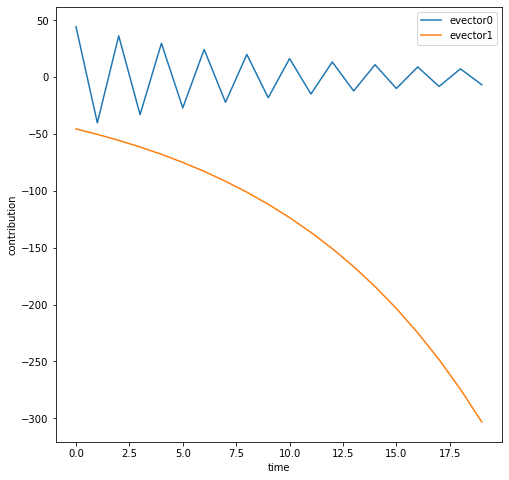

In [15]:
fig, ax = plt.subplots()
ax.plot(np.real(V))
ax.set_xlabel("time")
ax.set_ylabel("contribution")
ax.legend(['evector0', 'evector1']);
print(U)


## Example: right whales

For instance, the classes for females in a right whale population model were:

- class `C`: calves
- class `I`: immature
- class `M`: mature
- class `R`: reproductive

Individuals transition from calf to immature in one year;
can stay immature for more than one year;
then transition between mature and reproductive as adults.
Each class has a separate death rate,
and only reproductive individuals produce new offspring.
The parameters of the model are concisely encoded
in the following matrix:
$$
S =
\begin{array}{c c} & \begin{array}{@{} c c c c @{}} C\hphantom{0} & I\hphantom{0} & \hphantom{0}M & \hphantom{0}R \end{array} \\
    \begin{array}{c} C \\ I \\ M \\ R \end{array}\hspace{-1em} &
    \left(
        \begin{array}{@{} c c c c @{}}
        0 & 0 & 0 & b \\
        s_{IC} & s_{II} & 0 & 0 \\
        0 & s_{MI} & s_{MM} & s_{MR} \\
        0 & s_{RI} & s_{RM} & s_{RR} 
        \end{array}
    \right) \\ \mbox{} \end{array} \\[-12pt] 
$$
There are nine parameters.
All the $s_{XY}$ parameters have the same interpretation: they give the probability
that a given individual *currently in class $Y$* will be *in class $X$* next time step.
For instance, a calf will either
- become immature (with probability $s_{IC}$, or
- die (otherwise),

while an immature individual will either
- stay immature (probability $s_{II}$),
- become mature (probability $s_{MI}$), or
- become reproductive ($s_{RI}$).

The remaining parameter, $b$, is the mean number of *births* per reproductive individual per year.

In [18]:
whale_args = {
    "s_ic" : 0.92,
    "s_ii" : 0.86,
    "s_mi" : 0.08,
    "s_mm" : 0.8,
    "s_mr" : 1 - 0.12,
    "s_ri" : 0.02,
    "s_rm" : 0.19,
    "s_rr" : 0,
    "b" : 0.3
}

**Excercise:** Write a paragraph describing the whale models, with these parameters. (e.g., "*92% of the calves born each year survive until the next year, in which case they join the 'immature' class.*")

[ 1.00344623+0.j  0.82431021+0.j -0.00160662+0.j -0.16614981+0.j]


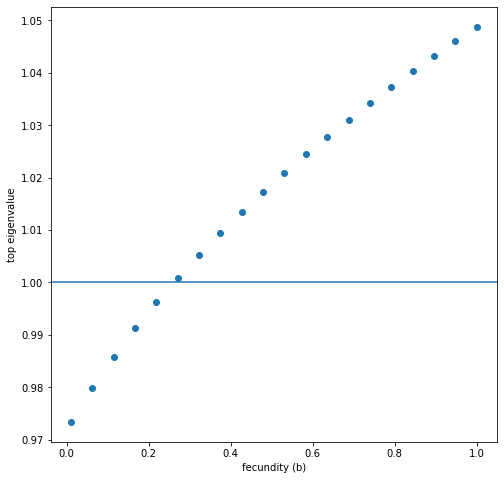

In [19]:
def make_S(s_ic, s_ii, s_mi, s_mm, s_mr, s_ri, s_rm, s_rr, b):
    S = np.array([[0,    0,    0,    b],
                  [s_ic, s_ii, 0,    0],
                  [0,    s_mi, s_mm, s_mr],
                  [0,    s_ri, s_rm, s_rr]])
    return S

S = make_S(**whale_args)

evals, evecs = linalg.eig(S)
print(evals)

def top_eig(b):
    # compute and return the largest eigenvalue from S
    args = whale_args
    args['b'] = b
    S = make_S(**args)
    evals, evecs = linalg.eig(S)
    return evals[np.argmax(evals)]

bvals = np.linspace(0.01, 1.0, 20)
eigs = [top_eig(b) for b in bvals]

plt.scatter(bvals, np.real(eigs))
plt.xlabel("fecundity (b)")
plt.ylabel("top eigenvalue")
plt.axhline(1.0);

That predicts that at $b=0.2$, the population will die out (slowly, decreasing by $\approx$ 99% per year),
and above $b=0.3$ it will not (again, increasing slowly).
Let's see.

1.147530443974088

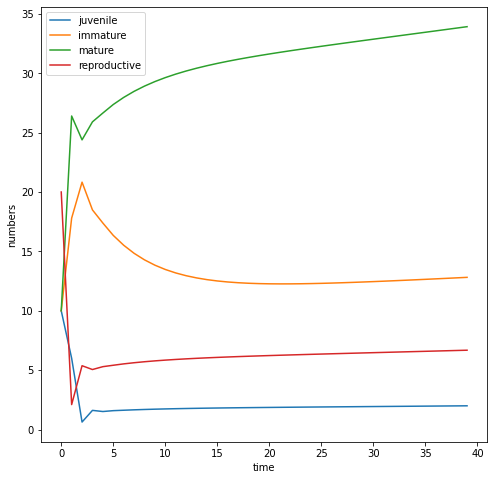

In [20]:
# initial conditions
N0 = [10, 10, 10, 20]

ntimes = 40
N = np.empty((ntimes, S.shape[0]), dtype='float')
N[0, :] = N0
for j in range(1, ntimes):
    N[j, :] = S @ N[j-1, :]
   
  
fig, ax = plt.subplots()
ax.plot(N)
ax.set_xlabel("time")
ax.set_ylabel("numbers")
ax.legend(['juvenile', 'immature', "mature", "reproductive"]);

# over this time we expect the population to have grown by a factor of
np.real(evals[0]) ** ntimes

0.33330631980620706

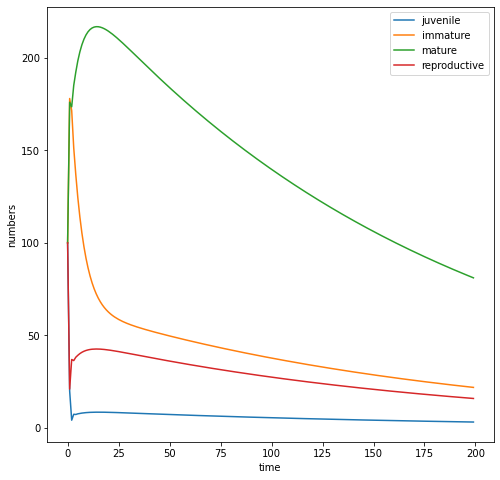

In [23]:
bad_whale_args = whale_args
bad_whale_args['b'] = 0.2
S_bad = make_S(**bad_whale_args)
bevals, bevecs = linalg.eig(S_bad)

N0 = [100, 100, 100, 100]
ntimes = 200
bN = np.empty((ntimes, S.shape[0]), dtype='float')
bN[0, :] = N0
for j in range(1, ntimes):
    bN[j, :] = S_bad @ bN[j-1, :]
   
  
fig, ax = plt.subplots()
ax.plot(bN)
ax.set_xlabel("time")
ax.set_ylabel("numbers")
ax.legend(['juvenile', 'immature', "mature", "reproductive"]);
# ax.set_yscale('log')

# over this time we expect the population to have grown by a factor of
np.real(bevals[np.argmax(bevals)]) ** ntimes

## Stable age distributions

Clearly, there's some nonequilibrium stuff going on at the start of those simulations.
I chose starting age distributions that weren't natural at all -- too many juveniles,
given the long lifetimes of adults and relatively low birth rates.
How could we have predicted this?

It turns out that in a linear model, the long-term behavior is governed
by the "top" eigenvalue and its eigenvectors.
Call $\lambda_0$ the largest eigenvalue (largest in absolute value; it is always real);
and $v$ the corresponding eigenvector.
Then

1. The long-term growth rate of the entire population is $\lambda_0$,
    i.e., $\sum_j N_j(t)$ grows like $\lambda_0^t$.
   
2. The long-term *age distribution* is proportional to $v$,
    i.e., $$ \frac{N_j(t) }{ \sum_k N_k(t) } \approx \frac{ v_j }{ \sum_k v_k }.$$

Let's check this in the whale model above.

In [24]:
-evecs[:, 0]

array([0.05407559, 0.34681668, 0.91873768, 0.18087316])

In [25]:
evecs[:, 0] / sum(evecs[:,0])

array([0.03603831, 0.23113359, 0.61228642, 0.12054168])

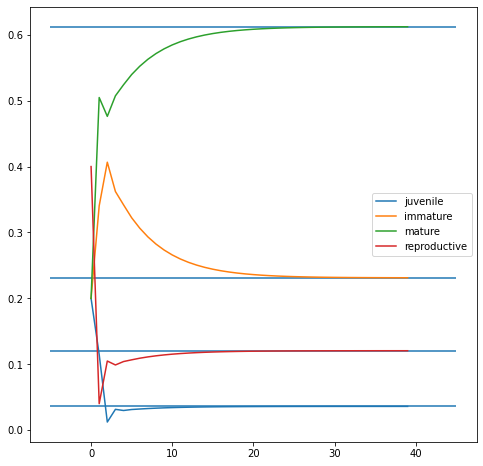

In [26]:
# good parameters
fig, ax = plt.subplots()
ax.hlines(evecs[:, 0]/sum(evecs[:, 0]), xmin=-5, xmax=45)
ax.plot(N / N.sum(axis=1, keepdims=True));
ax.legend(['juvenile', 'immature', "mature", "reproductive"]);


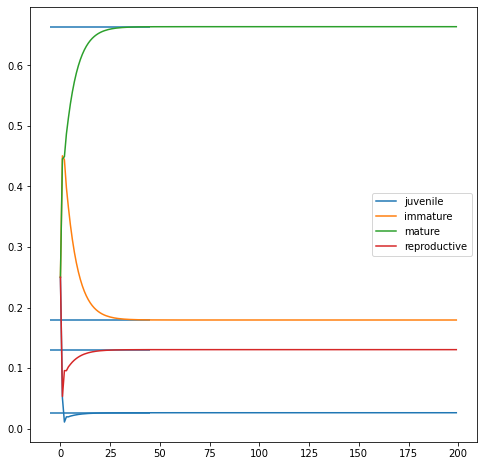

In [27]:
# bad parameters
fig, ax = plt.subplots()
ax.hlines(bevecs[:, 0]/sum(bevecs[:, 0]), xmin=-5, xmax=45)
ax.plot(bN / bN.sum(axis=1, keepdims=True));
ax.legend(['juvenile', 'immature', "mature", "reproductive"]);


# Homework

Modify the whale model to include randomness. See how well the growth rate and long-term age structure match the deterministic predictions. (They should match quite well!)